In [2]:
import pandas as pd
import numpy as np
import os
import pyfolio as pf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

plt.style.use('bmh')

/Users/danieloliveira/opt/anaconda3/envs/dcuoliveira/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [41]:
current_dir = os.getcwd()

target_file = "signals_bars_vols_costs.xlsx"
start_dt = "2008-04-01"
instruments_to_delete = ["USDCLP", "USDCOP"]

signals_df = pd.read_excel(os.path.join(current_dir, "data", target_file), sheet_name="sinal")
signals_df.index = pd.to_datetime(signals_df["date"])
signals_df.set_index("date", inplace=True)
signals_df.drop(instruments_to_delete, inplace=True, axis=1)

bars_df = pd.read_excel(os.path.join(current_dir, "data", target_file), sheet_name="bars")
bars_df.index = pd.to_datetime(bars_df["date"])
bars_df.set_index("date", inplace=True)
bars_df.drop(instruments_to_delete, inplace=True, axis=1)

vols_df = bars_df.pct_change().ewm(span=252/2, adjust=False).std() * np.sqrt(252)

costs_df = pd.read_excel(os.path.join(current_dir, "data", target_file), sheet_name="costs")
costs_df.index = pd.to_datetime(costs_df["date"])
costs_df.set_index("date", inplace=True)
costs_df.drop(instruments_to_delete, inplace=True, axis=1)

bars_df = bars_df.loc[start_dt:]
vols_df = vols_df.loc[start_dt:]
signals_df = signals_df.loc[start_dt:]
costs_df = costs_df.loc[start_dt:]

<AxesSubplot:xlabel='date'>

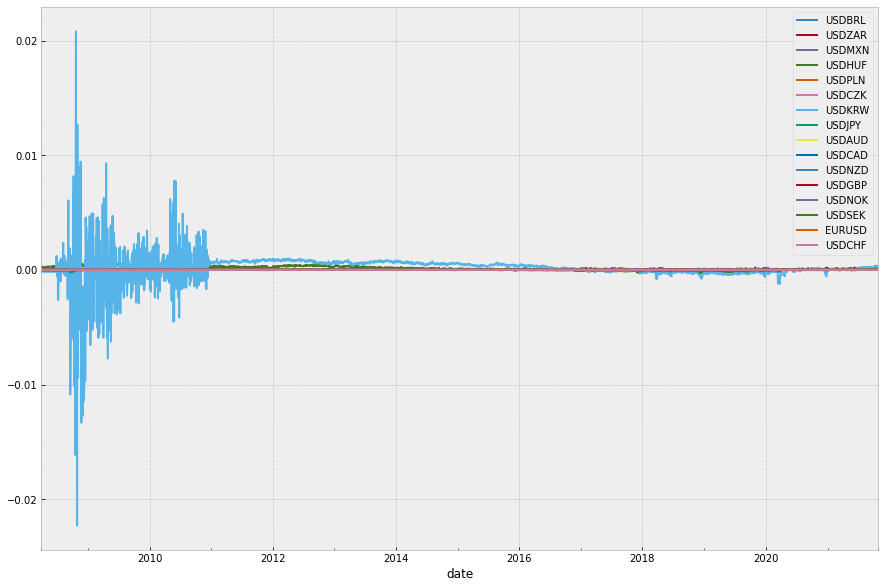

In [42]:
costs_df.plot(figsize=(15, 10))

<AxesSubplot:xlabel='date'>

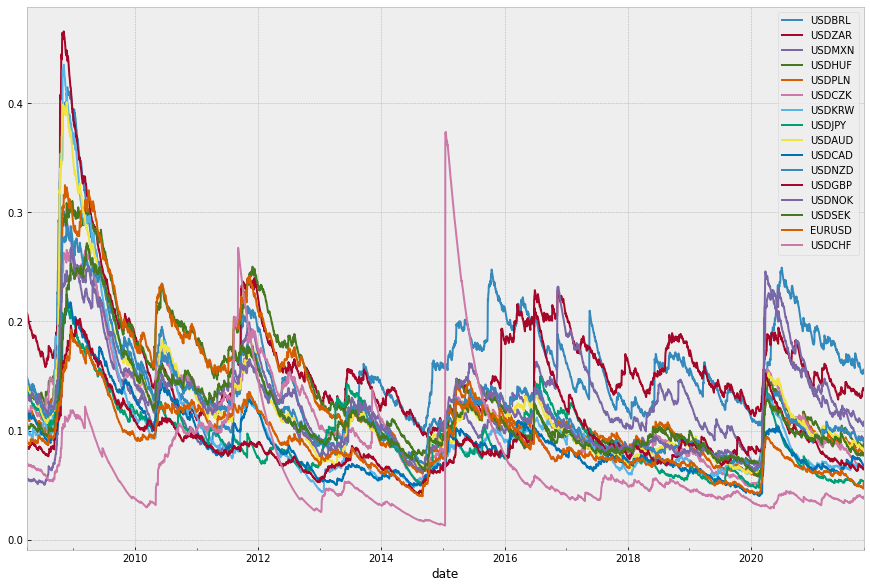

In [43]:
vols_df.plot(figsize=(15, 10))

<AxesSubplot:xlabel='date'>

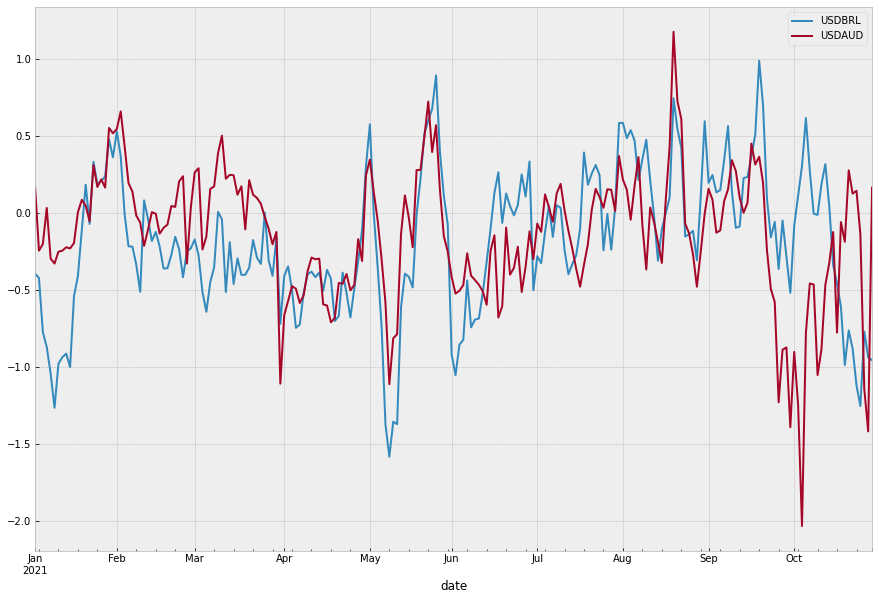

In [44]:
signals_df[["USDBRL", "USDAUD"]].loc["2021-01-01":].plot(figsize=(15, 10))

## Cross-Section portfolio

### 1. Equal weight 

In [45]:
rank_equalw_df = signals_df.rank(axis=1)

up_quantile_equalw = rank_equalw_df.quantile(q=0.8, axis=1)
down_quantile_equalw = rank_equalw_df.quantile(q=0.2, axis=1)

positions_equalw = pd.DataFrame(np.where(rank_equalw_df < down_quantile_equalw[:,None],
                                         -1,
                                         np.where(rank_equalw_df > up_quantile_equalw[:,None],
                                                  1,
                                                  0)),
                                columns=signals_df.columns,
                                index=signals_df.index)

sum_positive = positions_equalw[positions_equalw > 0].sum(axis=1)
sum_negative = positions_equalw[positions_equalw < 0].sum(axis=1)

positions_equalw = pd.DataFrame(np.where(positions_equalw > 0,
                                         positions_equalw.divide(sum_positive, axis=0),
                                         np.where(positions_equalw < 0,
                                                  -positions_equalw.divide(sum_negative, axis=0),
                                                  0)),
                                columns=positions_equalw.columns,
                                index=positions_equalw.index)

portfolio_equalw = positions_equalw.shift(2).multiply(bars_df.pct_change(), axis=0)

/var/folders/y5/gwwq15s92v97s_yvjxy3cqn40000gn/T/ipykernel_8594/1623476105.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  positions_equalw = pd.DataFrame(np.where(rank_equalw_df < down_quantile_equalw[:,None],
/var/folders/y5/gwwq15s92v97s_yvjxy3cqn40000gn/T/ipykernel_8594/1623476105.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  np.where(rank_equalw_df > up_quantile_equalw[:,None],


Start date,2008-04-01
End date,2021-10-29
Total months,168
,Backtest
Annual return,10.8%
Cumulative returns,324.7%
Annual volatility,8.6%
Sharpe ratio,1.24
Calmar ratio,0.92
Stability,0.96
Max drawdown,-11.8%


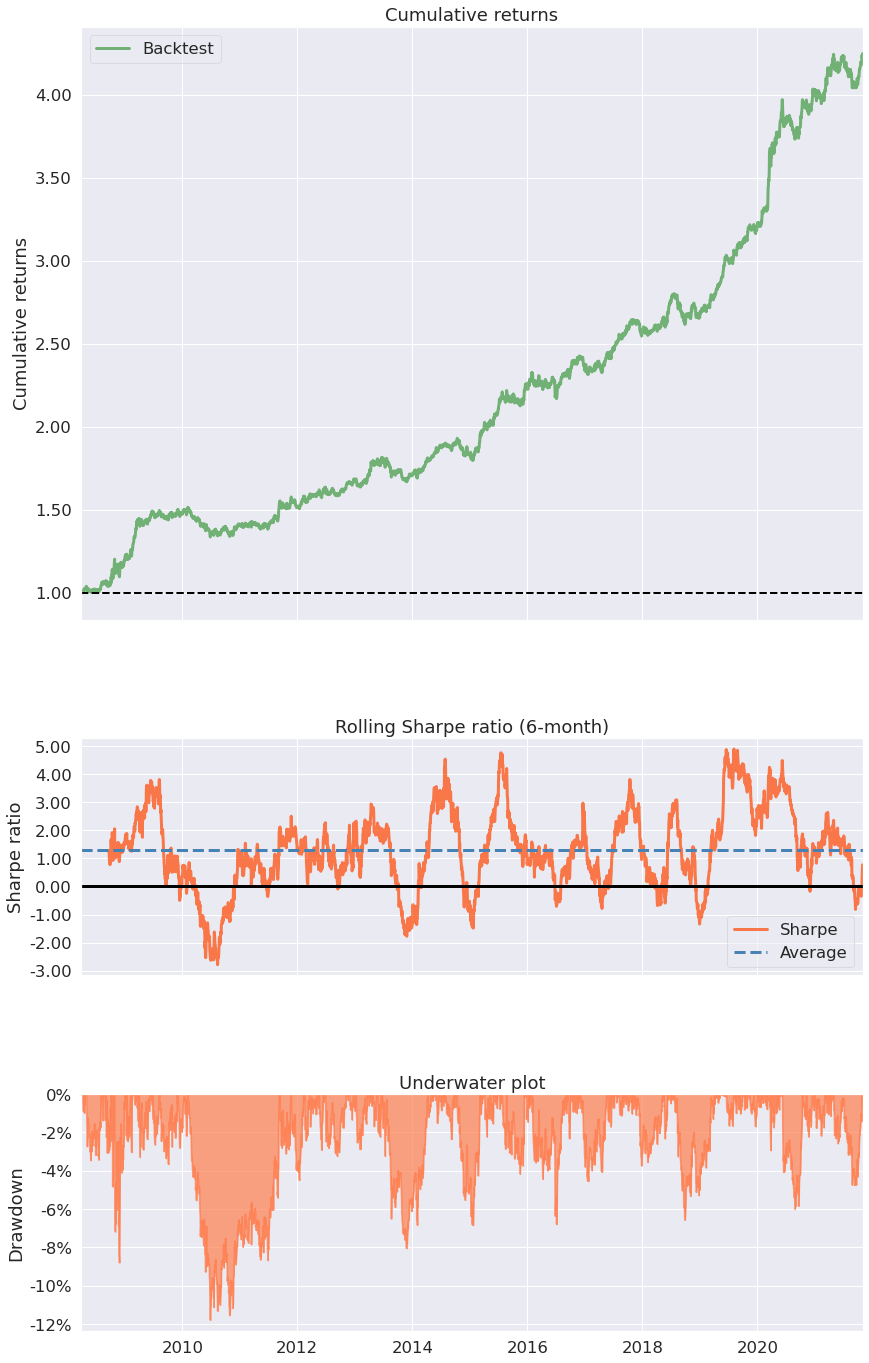

In [46]:
pf.create_simple_tear_sheet(portfolio_equalw.sum(axis=1))

<AxesSubplot:title={'center':'Annual returns'}, xlabel='Returns', ylabel='Year'>

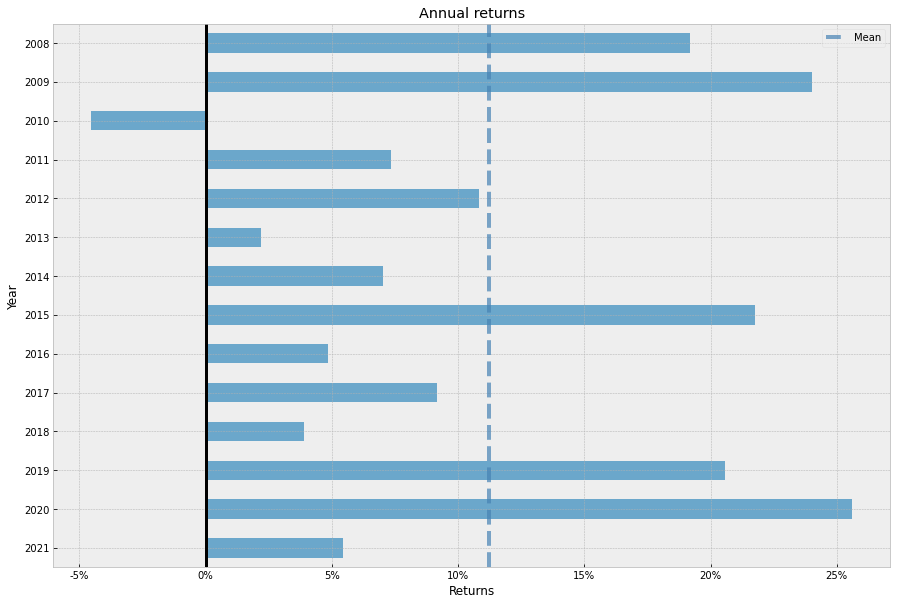

In [70]:
pf.plot_annual_returns(portfolio_equalw.sum(axis=1),
                       figsize=(15, 10))

### 2. Equal weight and Volatility Scaled  Portfolio Level

In [47]:
vol_target = 0.1

In [48]:
portfolio_equalw_vol_scaled_portfolio = portfolio_equalw.sum(axis=1)
portfolio_rolling_annvol_vol_scaled_portfolio = portfolio_equalw_vol_scaled_portfolio.rolling(window=252).std() * np.sqrt(252)

portfolio_returns_vol_ap_vol_scaled_portfolio = portfolio_equalw_vol_scaled_portfolio.multiply(vol_target / portfolio_rolling_annvol_vol_scaled_portfolio, axis=0)

Start date,2009-03-18
End date,2021-10-29
Total months,156
,Backtest
Annual return,12.6%
Cumulative returns,373.8%
Annual volatility,9.9%
Sharpe ratio,1.25
Calmar ratio,0.86
Stability,0.94
Max drawdown,-14.7%


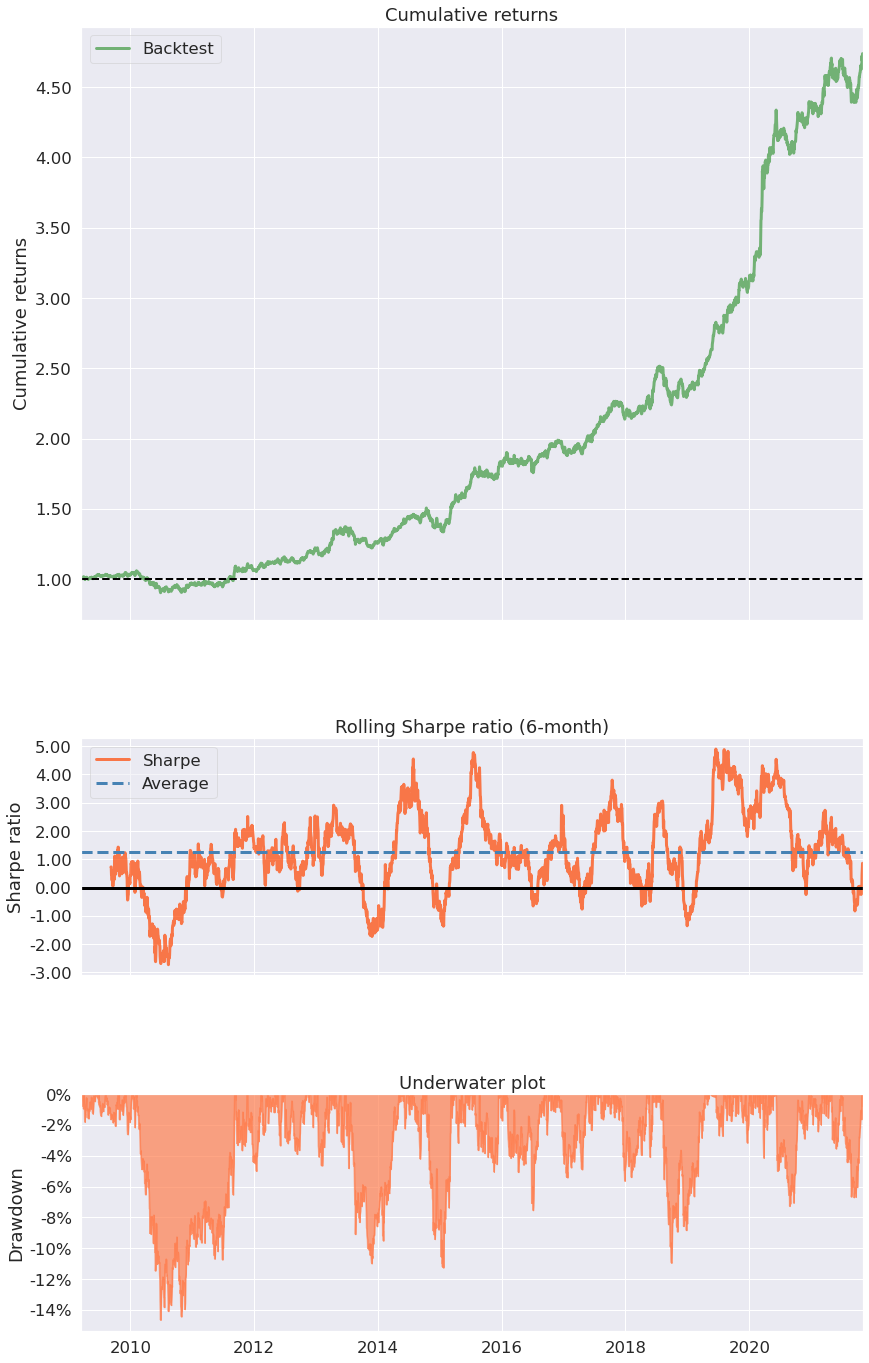

In [49]:
pf.create_simple_tear_sheet(portfolio_returns_vol_ap_vol_scaled_portfolio.dropna())

### 3. Equal weight and Volatility Scaled Asset Level

In [50]:
positions_equalw_vol_scaled = positions_equalw.multiply(vol_target / vols_df.shift(2), axis=0)

portfolio_equalw_vol_scaled = positions_equalw_vol_scaled.shift(2).multiply(bars_df.pct_change(), axis=0)

Start date,2008-04-01
End date,2021-10-29
Total months,168
,Backtest
Annual return,10.2%
Cumulative returns,289.7%
Annual volatility,7.1%
Sharpe ratio,1.39
Calmar ratio,1.03
Stability,0.93
Max drawdown,-9.9%


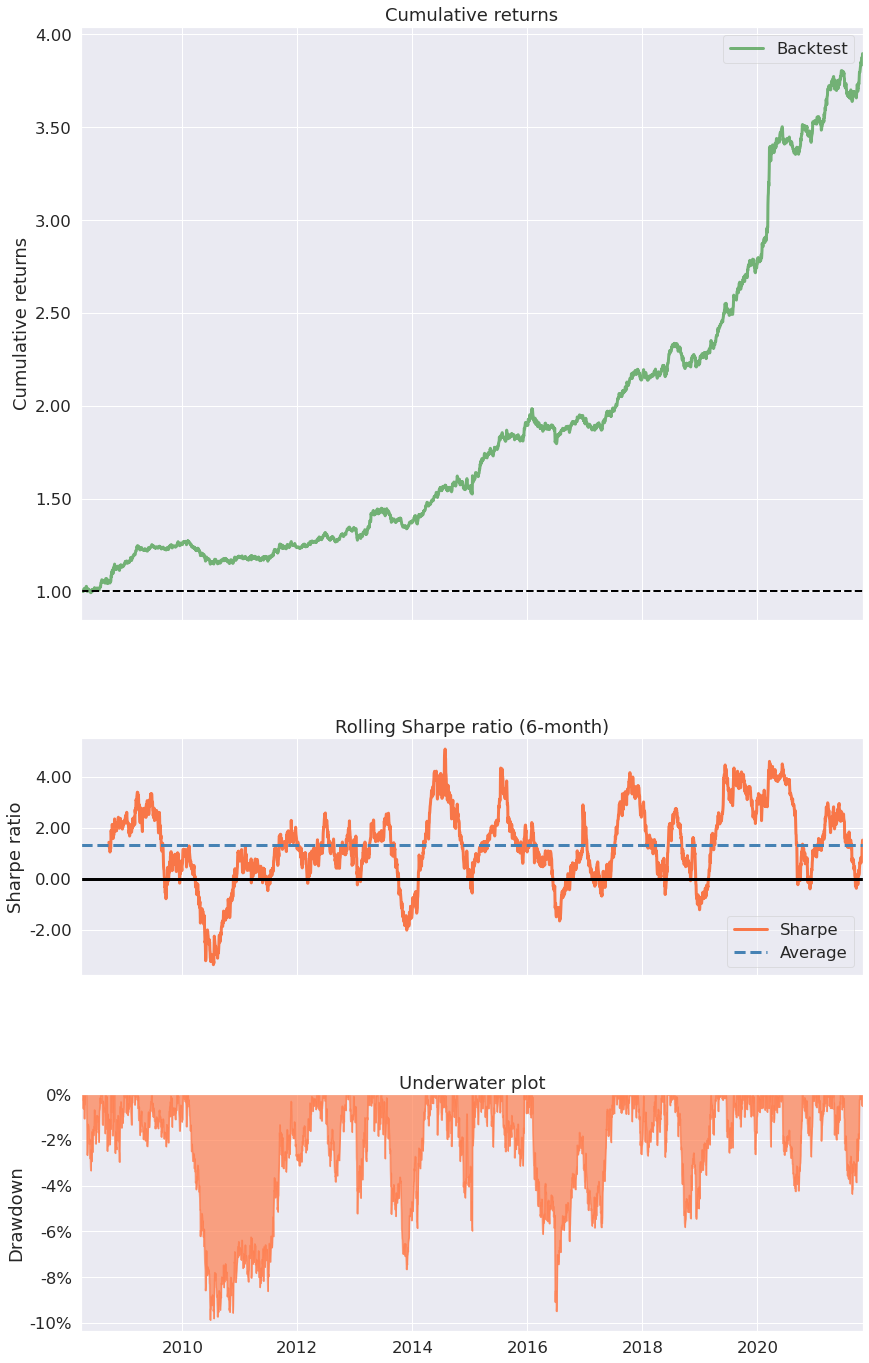

In [51]:
pf.create_simple_tear_sheet(portfolio_equalw_vol_scaled.sum(axis=1))

### 4. Equal weight and Volatility Scaled Asset and Portfolio Level

In [52]:
portfolio_returns = portfolio_equalw_vol_scaled.sum(axis=1)
portfolio_rolling_annvol = portfolio_returns.rolling(window=252).std() * np.sqrt(252)

portfolio_returns_vol_ap = portfolio_returns.multiply(vol_target / portfolio_rolling_annvol, axis=0)

Start date,2009-03-18
End date,2021-10-29
Total months,156
,Backtest
Annual return,12.9%
Cumulative returns,390.1%
Annual volatility,10.2%
Sharpe ratio,1.25
Calmar ratio,0.67
Stability,0.92
Max drawdown,-19.4%


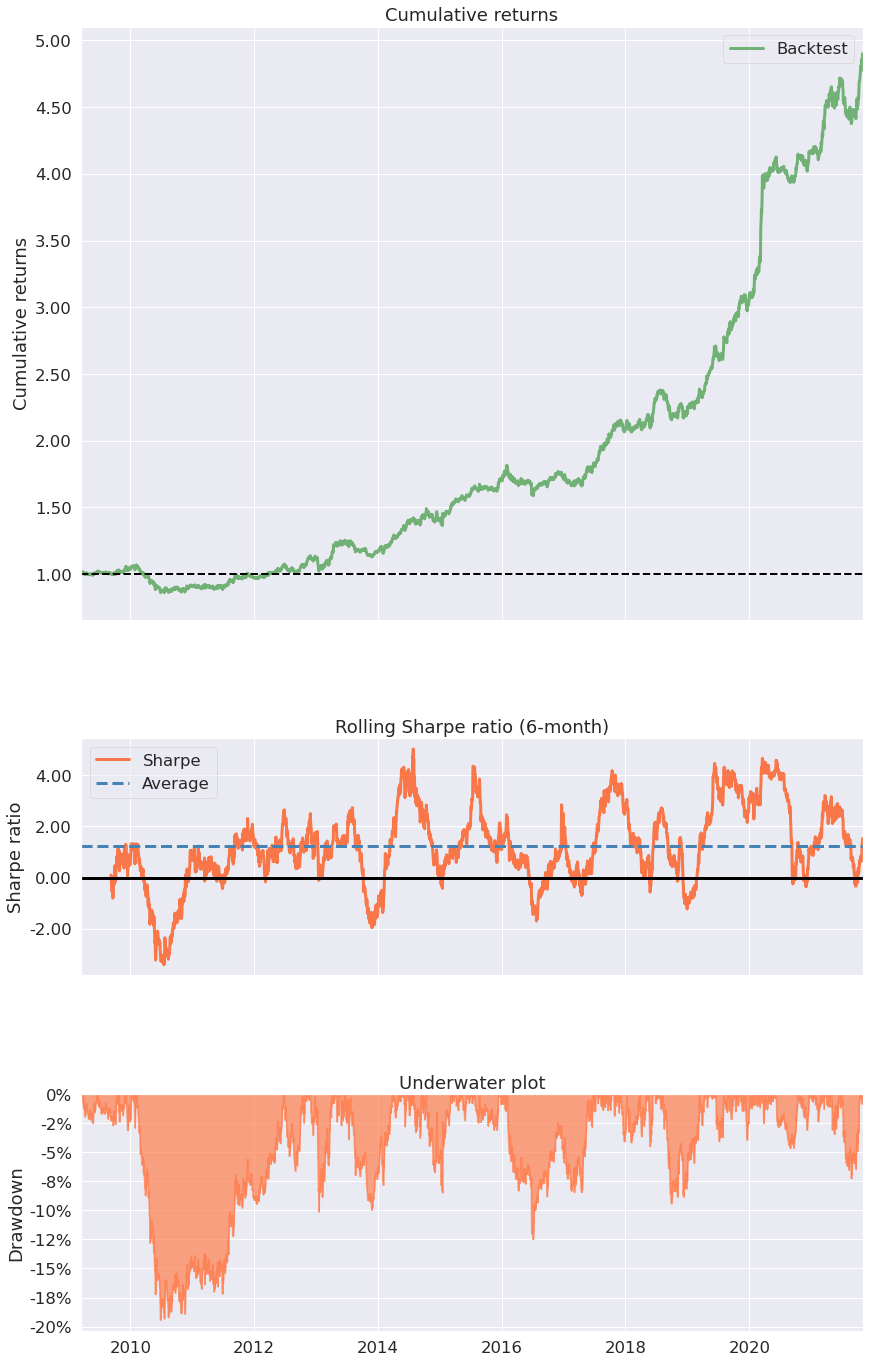

In [53]:
pf.create_simple_tear_sheet(portfolio_returns_vol_ap.dropna())

### 5. Equal weight, Volatility Scaled Asset and Portfolio Level, and Volatility Regime Switching Overlay

<AxesSubplot:xlabel='date'>

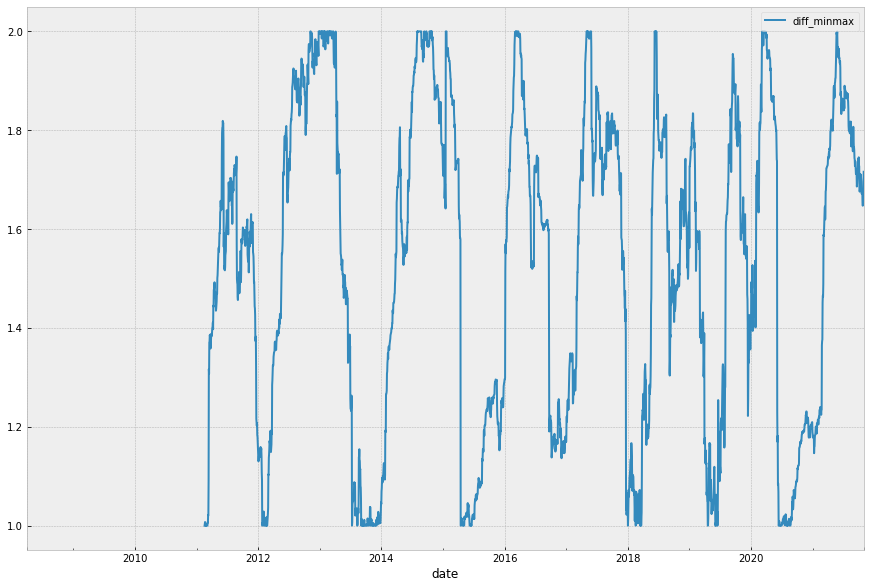

In [54]:
slow_vol = portfolio_returns_vol_ap.rolling(window=252).std() * np.sqrt(252)
fast_vol = portfolio_returns_vol_ap.rolling(window=int(252/12 * 3)).std() * np.sqrt(252)

vol_switching = pd.concat([slow_vol, fast_vol], axis=1)
vol_switching.columns = ["slow vol", "fast vol"]
vol_switching["diff"] = vol_switching["fast vol"] - vol_switching["slow vol"]
vol_switching["diff_minmax"] = (vol_switching["diff"] - vol_switching["diff"].rolling(window=252).min()) / (vol_switching["diff"].rolling(window=252).max() - vol_switching["diff"].rolling(window=252).min()) + 1

vol_switch = vol_switching[["diff_minmax"]]
vol_switch.plot(figsize=(15, 10))

In [55]:
positions_equalw_vol_scaled_vol_switch = positions_equalw_vol_scaled.divide(vol_switch["diff_minmax"].shift(2), axis=0)

portfolio_equalw_vol_scaled_vol_switch = positions_equalw_vol_scaled_vol_switch.shift(2).multiply(bars_df.pct_change(), axis=0)

portfolio_returns_vol_switch = portfolio_equalw_vol_scaled_vol_switch.sum(axis=1)
portfolio_rolling_annvol_vol_switch = portfolio_returns_vol_switch.rolling(window=252).std() * np.sqrt(252)

portfolio_returns_vol_ap_vol_switch = portfolio_returns_vol_switch.multiply(vol_target / portfolio_rolling_annvol_vol_switch, axis=0)

### 6. Equal weight, Volatility Scaled Asset and Portfolio Level, and Momentum overlay

In [79]:
slow_mom = portfolio_returns_vol_ap.rolling(window=252).mean()
fast_mom = portfolio_returns_vol_ap.rolling(window=int(252/12 * 6)).mean()

mom_switching = pd.concat([slow_mom, fast_mom], axis=1)
mom_switching.columns = ["slow mom", "fast mom"]

<AxesSubplot:xlabel='date'>

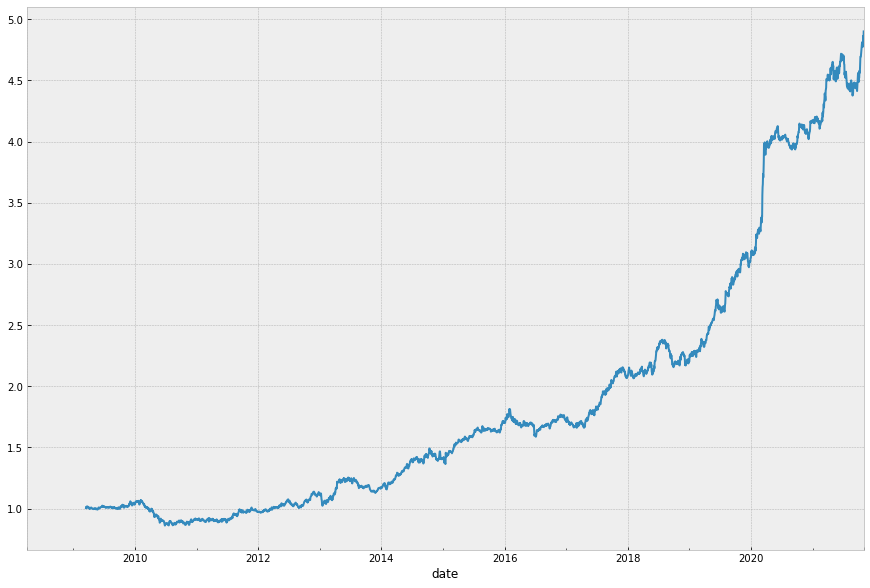

In [80]:
(1+portfolio_returns_vol_ap).cumprod().plot(figsize=(15, 10))

<AxesSubplot:xlabel='date'>

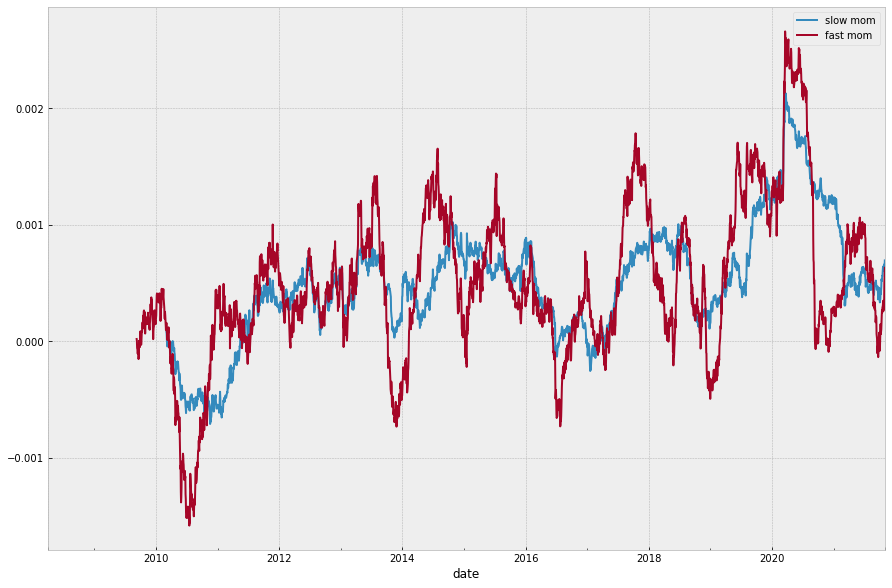

In [81]:
mom_switching.plot(figsize=(15, 10))

<AxesSubplot:xlabel='date'>

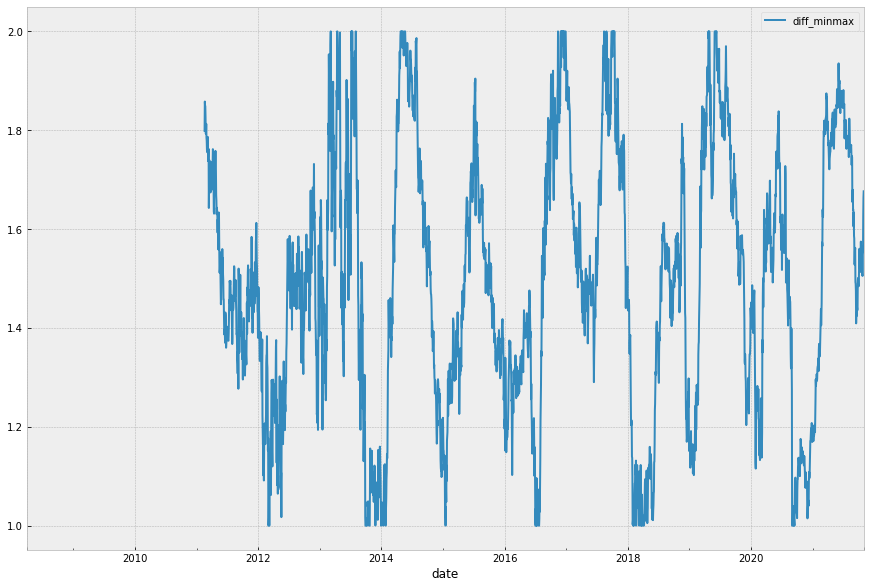

In [83]:
mom_switching["diff"] = mom_switching["fast mom"] - mom_switching["slow mom"]
mom_switching["diff_minmax"] = (mom_switching["diff"] - mom_switching["diff"].rolling(window=252).min()) / (mom_switching["diff"].rolling(window=252).max() - mom_switching["diff"].rolling(window=252).min()) + 1

mom_switching = mom_switching[["diff_minmax"]]
mom_switching.plot(figsize=(15, 10))

In [84]:
positions_equalw_vol_scaled_mom_switch = positions_equalw_vol_scaled.divide(mom_switching["diff_minmax"].shift(2), axis=0)

portfolio_equalw_vol_scaled_mom_switch = positions_equalw_vol_scaled_mom_switch.shift(2).multiply(bars_df.pct_change(), axis=0)

portfolio_returns_mom_switch = portfolio_equalw_vol_scaled_mom_switch.sum(axis=1)
portfolio_rolling_annvol_mom_switch = portfolio_returns_mom_switch.rolling(window=252).std() * np.sqrt(252)

portfolio_returns_vol_ap_mom_switch = portfolio_returns_mom_switch.multiply(vol_target / portfolio_rolling_annvol_mom_switch, axis=0)

Start date,2011-02-24
End date,2021-10-29
Total months,132
,Backtest
Annual return,16.8%
Cumulative returns,455.9%
Annual volatility,12.7%
Sharpe ratio,1.28
Calmar ratio,0.92
Stability,0.95
Max drawdown,-18.3%


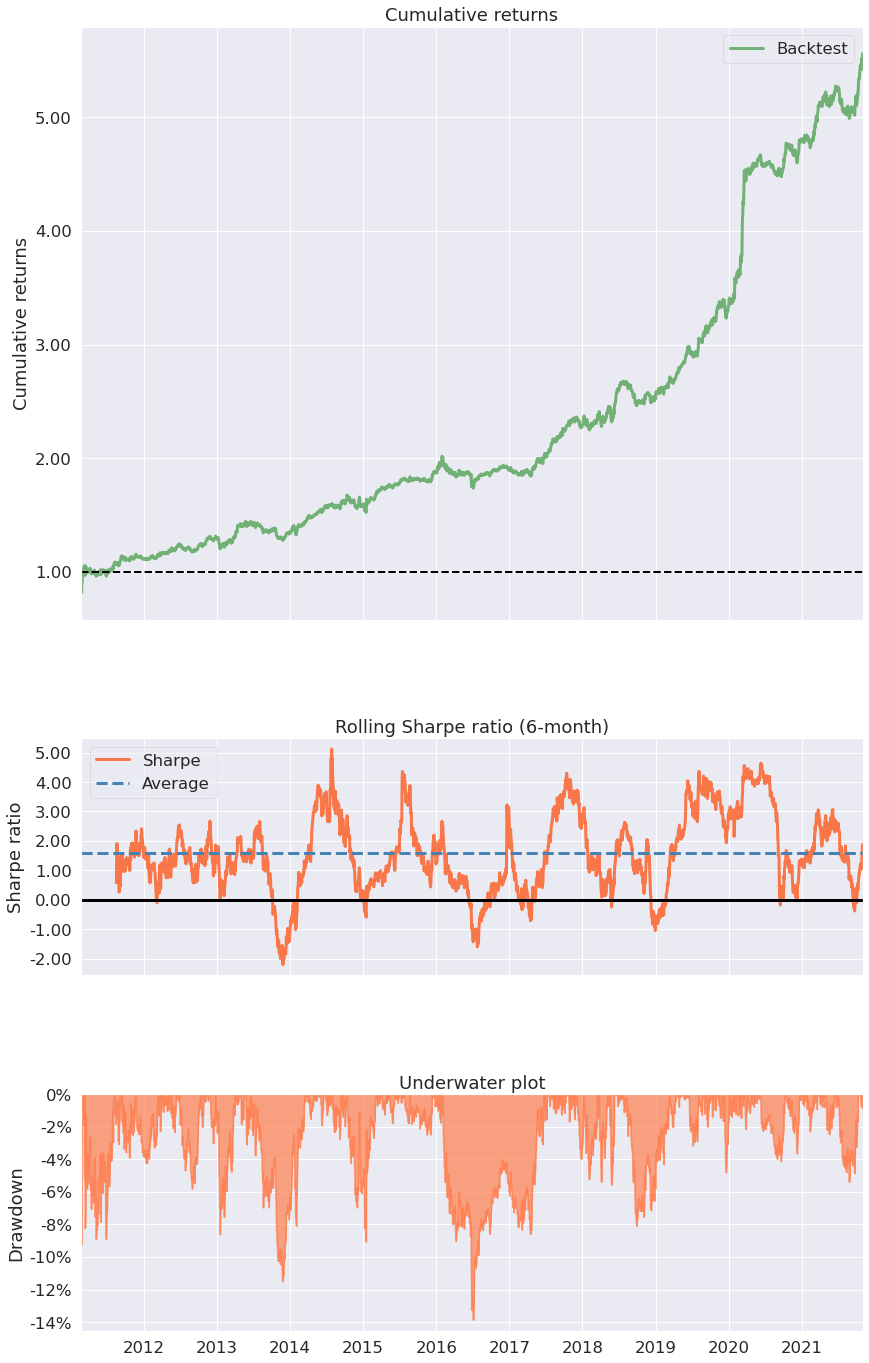

In [85]:
pf.create_simple_tear_sheet(portfolio_returns_vol_ap_mom_switch.dropna())

<AxesSubplot:xlabel='date'>

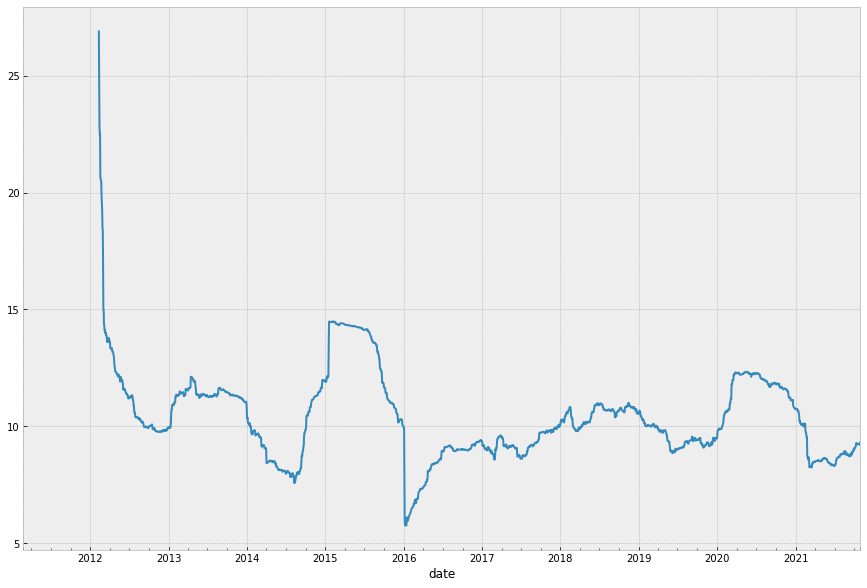

In [34]:
(portfolio_returns_vol_ap_mom_switch.dropna().rolling(window=252).std() * np.sqrt(252) * 100).plot(figsize=(15, 10))

<AxesSubplot:title={'center':'Annual returns'}, xlabel='Returns', ylabel='Year'>

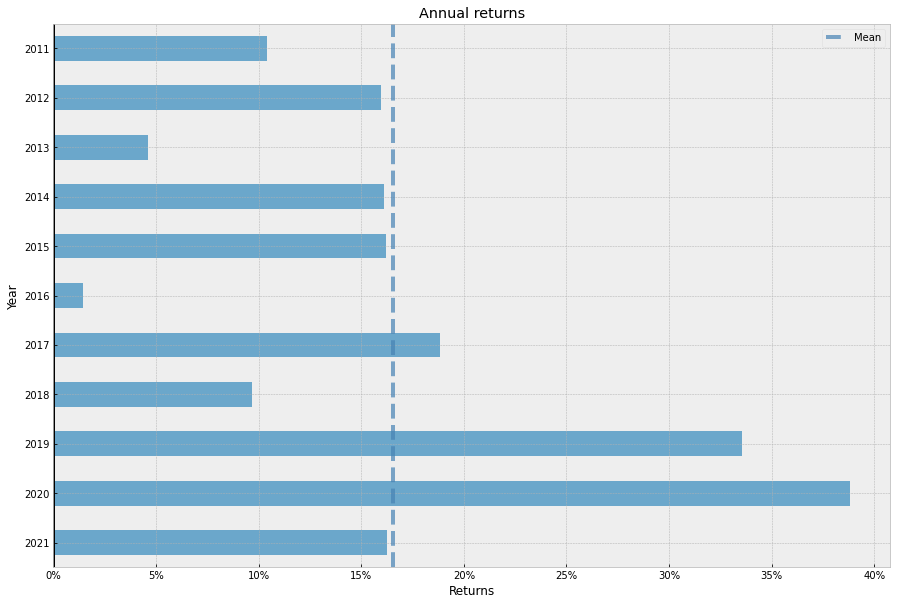

In [69]:
pf.plot_annual_returns(portfolio_returns_vol_ap_mom_switch.dropna(),
                       figsize=(15, 10))

In [24]:
cs_summary = pd.read_clipboard()

In [36]:
cs_summary = pd.read_clipboard()

In [37]:
cs_summary

,Equal weight,Equal Weight Vol. Scaled Asset Level,Equal Weight Vol. Scaled Asset and Portfolio Level,"Equal Weight Vol. Scaled Asset and Portfolio Level, and Vol. Switching","Equal Weight Vol. Scaled Asset and Portfolio Level, and Mom. Switching"
Annual return,9.3%,8.5%,12.3%,15.5%,10.2%
Cumulative returns,247.5%,213.5%,356.3%,390.3%,246.8%
Annual volatility,7.5%,6.3%,10.2%,12.5%,12.0%
Sharpe ratio,1.22,1.32,1.19,1.22,0.87
Calmar ratio,0.64,0.80,0.58,0.83,0.24
Stability,0.95,0.90,0.88,0.92,0.91
Max drawdown,-14.6%,-10.6%,-21.1%,-18.6%,-42.7%
Omega ratio,1.24,1.26,1.23,1.27,1.18
Sortino ratio,1.83,2.03,1.80,1.77,1.25
Skew,-0.28,0.24,0.10,-0.90,-0.56


## What factors are driven the returns of the portfolio?

In [75]:
betas_df = pd.read_excel(os.path.join(current_dir, "data", target_file), sheet_name="betas")
betas_df.index = pd.to_datetime(betas_df["date"])
betas_df.set_index("date", inplace=True)

portfolios_rets = pd.concat([portfolio_equalw.sum(axis=1), portfolio_equalw_vol_scaled.sum(axis=1),
                             portfolio_returns_vol_ap, portfolio_returns_vol_ap_vol_switch, portfolio_returns_vol_ap_mom_switch], axis=1)
portfolios_rets.columns = ["equal weight", "equal weight vol scale assets", "equal weight vol scale assets n port",
                           "equal weight vol scale assets n port vol switch", "equal weight vol scale assets n port mom switch"]
portfolios_rets = portfolios_rets * 100

reg_df = pd.concat([betas_df, portfolios_rets], axis=1)
reg_df = sm.add_constant(reg_df, prepend=False)
reg_df = reg_df.dropna()

In [77]:
mod1 = sm.OLS(reg_df[["equal weight"]], reg_df[["const", "DXY Curncy", "SPX Index"]])
print(mod1.fit().summary())

                            OLS Regression Results                            
Dep. Variable:           equal weight   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     7.575
Date:                Sun, 31 Oct 2021   Prob (F-statistic):           0.000524
Time:                        18:54:49   Log-Likelihood:                -1406.6
No. Observations:                2786   AIC:                             2819.
Df Residuals:                    2783   BIC:                             2837.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0385      0.008      5.064      0.0

In [78]:
mod2 = sm.OLS(reg_df[["equal weight vol scale assets"]], reg_df[["const", "DXY Curncy", "SPX Index"]])
print(mod2.fit().summary())

                                  OLS Regression Results                                 
Dep. Variable:     equal weight vol scale assets   R-squared:                       0.011
Model:                                       OLS   Adj. R-squared:                  0.010
Method:                            Least Squares   F-statistic:                     15.06
Date:                           Sun, 31 Oct 2021   Prob (F-statistic):           3.13e-07
Time:                                   18:55:21   Log-Likelihood:                -1383.1
No. Observations:                           2786   AIC:                             2772.
Df Residuals:                               2783   BIC:                             2790.
Df Model:                                      2                                         
Covariance Type:                       nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------

In [79]:
mod3 = sm.OLS(reg_df[["equal weight vol scale assets n port"]], reg_df[["const", "DXY Curncy", "SPX Index"]])
print(mod3.fit().summary())

                                     OLS Regression Results                                     
Dep. Variable:     equal weight vol scale assets n port   R-squared:                       0.008
Model:                                              OLS   Adj. R-squared:                  0.008
Method:                                   Least Squares   F-statistic:                     11.91
Date:                                  Sun, 31 Oct 2021   Prob (F-statistic):           7.11e-06
Time:                                          18:55:44   Log-Likelihood:                -2717.4
No. Observations:                                  2786   AIC:                             5441.
Df Residuals:                                      2783   BIC:                             5459.
Df Model:                                             2                                         
Covariance Type:                              nonrobust                                         
                 coef    std e

In [81]:
mod4 = sm.OLS(reg_df[["equal weight vol scale assets n port vol switch"]], reg_df[["const", "DXY Curncy", "SPX Index"]])
print(mod4.fit().summary())

                                           OLS Regression Results                                          
Dep. Variable:     equal weight vol scale assets n port vol switch   R-squared:                       0.005
Model:                                                         OLS   Adj. R-squared:                  0.004
Method:                                              Least Squares   F-statistic:                     7.108
Date:                                             Sun, 31 Oct 2021   Prob (F-statistic):           0.000834
Time:                                                     18:56:19   Log-Likelihood:                -3269.4
No. Observations:                                             2786   AIC:                             6545.
Df Residuals:                                                 2783   BIC:                             6563.
Df Model:                                                        2                                         
Covariance Type:            

In [82]:
mod4 = sm.OLS(reg_df[["equal weight vol scale assets n port mom switch"]], reg_df[["const", "DXY Curncy", "SPX Index"]])
print(mod4.fit().summary())

                                           OLS Regression Results                                          
Dep. Variable:     equal weight vol scale assets n port mom switch   R-squared:                       0.006
Model:                                                         OLS   Adj. R-squared:                  0.006
Method:                                              Least Squares   F-statistic:                     8.993
Date:                                             Sun, 31 Oct 2021   Prob (F-statistic):           0.000128
Time:                                                     18:57:03   Log-Likelihood:                -2696.0
No. Observations:                                             2786   AIC:                             5398.
Df Residuals:                                                 2783   BIC:                             5416.
Df Model:                                                        2                                         
Covariance Type:            

## Does Fast Macro Momentum proxy drives the cross-section of currencies returns?

In [159]:
signals_reg_df = signals_df.copy().shift(2)
signals_reg_df = signals_reg_df.reset_index()
signals_reg_df.index = pd.to_datetime(signals_reg_df.index)
signals_reg_df = signals_reg_df.melt("date")
signals_reg_df["type"] = "Fast Macro Momentum t-2"

bars_reg_df = bars_df.pct_change().copy() * 100
bars_reg_df = bars_reg_df.reset_index()
bars_reg_df.index = pd.to_datetime(bars_reg_df.index) 
bars_reg_df = bars_reg_df.melt("date")
bars_reg_df["type"] = "fx returns t"

panelreg_df = pd.concat([signals_reg_df, bars_reg_df], axis=0)
panelreg_df = panelreg_df.pivot_table(index=["variable", "date"], columns=["type"], values=["value"])
panelreg_df.columns = panelreg_df.columns.droplevel() 
panelreg_df = panelreg_df.dropna()

In [156]:
panelmod = PanelOLS(dependent=panelreg_df[["fx returns t"]],
                    exog=panelreg_df[["Fast Macro Momentum t"]],
                    entity_effects=True)
res = panelmod.fit(cov_type='unadjusted')
res

Dep. Variable:,fx returns t,R-squared:,0.0103
Estimator:,PanelOLS,R-squared (Between):,-0.0031
No. Observations:,60231,R-squared (Within):,0.0103
Date:,"Sun, Oct 31 2021",R-squared (Overall):,0.0103
Time:,19:38:42,Log-likelihood,-7.141e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,626.65
Entities:,17,P-value,0.0000
Avg Obs:,3543.0,Distribution:,"F(1,60213)"
Min Obs:,3543.0,,
Max Obs:,3543.0,F-statistic (robust):,626.65


In [158]:
panelmod = PanelOLS(dependent=panelreg_df[["fx returns t"]],
                    exog=panelreg_df[["Fast Macro Momentum t-1"]],
                    entity_effects=True)
res = panelmod.fit(cov_type='unadjusted')
res

Dep. Variable:,fx returns t,R-squared:,0.0013
Estimator:,PanelOLS,R-squared (Between):,0.0029
No. Observations:,60231,R-squared (Within):,0.0013
Date:,"Sun, Oct 31 2021",R-squared (Overall):,0.0013
Time:,19:38:56,Log-likelihood,-7.168e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,78.360
Entities:,17,P-value,0.0000
Avg Obs:,3543.0,Distribution:,"F(1,60213)"
Min Obs:,3543.0,,
Max Obs:,3543.0,F-statistic (robust):,78.360


In [161]:
panelmod = PanelOLS(dependent=panelreg_df[["fx returns t"]],
                    exog=panelreg_df[["Fast Macro Momentum t-2"]],
                    entity_effects=True)
res = panelmod.fit(cov_type='unadjusted')
res

Dep. Variable:,fx returns t,R-squared:,0.0010
Estimator:,PanelOLS,R-squared (Between):,0.0036
No. Observations:,60214,R-squared (Within):,0.0010
Date:,"Sun, Oct 31 2021",R-squared (Overall):,0.0010
Time:,19:39:15,Log-likelihood,-7.167e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,62.113
Entities:,17,P-value,0.0000
Avg Obs:,3542.0,Distribution:,"F(1,60196)"
Min Obs:,3542.0,,
Max Obs:,3542.0,F-statistic (robust):,62.113
